In [2]:
import os

import numpy as np
import pandas as pd
import cvxpy as cp
from numba import jit

from sklearn.covariance import shrunk_covariance
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

/home/ezavalnyuk/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
FEATURES_DIR = './features'
FEATURES_DIR = os.path.abspath(FEATURES_DIR)
print (FEATURES_DIR)

/home/ezavalnyuk/dev/algopack/features


In [4]:
def neutralize(weights):
    return weights.sub(weights.mean(axis=1), axis=0)

def scale(weights):
    return weights.div(weights.abs().sum(axis=1), axis=0)

def truncate(weights, max_weight=0.05):
    return weights.clip(-max_weight, max_weight)

def truncate_and_normalize(weights, max_weight=0.05):
    weights = neutralize(weights)
    weights = scale(weights)
    for _ in range(5):
        weights = truncate(weights, max_weight)
        weights = neutralize(weights)
        weights = scale(weights)
    return weights

In [5]:
def ts_mean(df, window):
    return df.rolling(window).mean()

def ts_sum(df, window):
    return df.rolling(window).sum()

def ts_min(df, window):
    return df.rolling(window).min()

def ts_max(df, window):
    return df.rolling(window).max()

def ts_std(df, window):
    return df.rolling(window).std()

def ts_zscore(df, window):
    return (df - df.rolling(window).mean()) / df.rolling(window).std()

def cs_rank(df):
    return df.rank(axis=1, pct=1)

@jit(nopython=True)
def rank_of_last(arr):
    # returns rank of the last element in the series
    # `arr` is required to be of type numpy array
    x = arr[-1]
    
    if np.isnan(x):
        return np.nan
    
    g = np.sum(arr > x)
    l = np.sum(arr < x)
    eq = np.sum(arr == x)
    n = g + l + eq
    
    if n == 1:
        return 0.5
    
    return (l + 0.5 * (eq - 1)) / (n-1)

@jit(nopython=True)
def jit_ts_rank(M, window):
    height, width = M.shape
    R = np.zeros((height, width), dtype=np.float64)
    for j in range(width):
        for i in range(height):
            if i < window-1:
                R[i, j] = np.nan
            else:
                R[i, j] = rank_of_last(M[i-window+1:i+1, j])
    return R

def ts_rank(df, window):
    return pd.DataFrame(jit_ts_rank(df.values, window), index=df.index, columns=df.columns)

In [6]:
class Simulator:
    def __init__(self, features_dir, from_date=None, to_date=None, session_start_time=None, session_end_time=None):
        self.features_dir = features_dir
        self.dates = sorted(os.listdir(features_dir))
        if from_date is not None:
            self.dates = [date for date in self.dates if date >= from_date]
        if to_date is not None:
            self.dates = [date for date in self.dates if date <= to_date]
        self.feature_names = np.unique(np.concatenate([[os.path.splitext(filename)[0] for filename in os.listdir(os.path.join(self.features_dir, date))] for date in self.dates]))
        
        # filter out weekends and holidays based on trading activity
        trading_dates = list()
        for date in self.dates:
            if pd.read_parquet(os.path.join(FEATURES_DIR, date, 'trade_val.parquet')).sum(axis=0).sum() > 0:
                trading_dates.append(date)
        print ("Identified {} trading dates out of {}".format(len(trading_dates), len(self.dates)))
        self.dates = trading_dates
        self.tickers = None
        
        self.session_start_time = session_start_time
        self.session_end_time = session_end_time
        
        self.init_data()
        self.timeline_5m = self.data['trade_pr_close'].index
        
        self.init_tickers()
        self.init_universes()
        self.timeline_1d = self.universe_1d['all'].index
        
    def init_data(self):
        self.data = dict()
        
        # for stats calculation we must have feature `trade_pr_close`
        self.load_feature('trade_pr_close')
        self.load_feature('trade_val')
    
    def init_tickers(self):
        self.tickers = self.get_data('trade_pr_close').columns.tolist()
        
        trade_val = self.get_data('trade_val')
        total_trade_val = trade_val.sum(axis=0)
        ix = total_trade_val == 0
        if ix.sum():
            empty_tickers = total_trade_val[ix].index.tolist()
            print ("Identified tickers with empty history: {}: dropping".format(empty_tickers))
            self.tickers = np.setdiff1d(self.tickers, empty_tickers)
        
        # hard code
        manually_exclude_tickers = ['ACKO', 'GAZC', 'GAZS', 'GAZT', 'SVETP']
        self.tickers = np.setdiff1d(self.tickers, manually_exclude_tickers)
        
        self.data['trade_pr_close'] = self.data['trade_pr_close'][self.tickers]
        self.data['trade_val'] = self.data['trade_val'][self.tickers]
    
    def init_universes(self):
        trading_value = self.data['trade_val']
        daily_trading_value = trading_value.groupby(pd.to_datetime(trading_value.index.strftime('%Y-%m-%d'))).sum()
        trading_value_30days_rank = daily_trading_value.rolling(30, min_periods=1).sum().rank(axis=1, ascending=False)
        
        self.universe_1d = dict()
        for n in [25, 50, 100, 200]:
            self.universe_1d[f'top_{n}'] = (trading_value_30days_rank <= n).fillna(False)
        self.universe_1d['all'] = (trading_value_30days_rank <= trading_value_30days_rank.shape[1]).fillna(False)
        
        self.universe_5m = dict()
        for uname, u in self.universe_1d.items():
            u = u.copy()
            u.index = u.index + pd.Timedelta(self.session_start_time) + pd.Timedelta(minutes=5)
            self.universe_5m[uname] = u.reindex(self.timeline_5m).ffill()
        
    def get_data(self, feature_name):
        if feature_name not in self.data:
            self.load_feature(feature_name)
        return self.data[feature_name]
    
    def load_feature(self, feature_name):
        if feature_name in self.data:
            return False
        print (f"Loading `{feature_name}` from disk")
        features = list()
        for date in self.dates:
            feature_path = os.path.join(self.features_dir, date, f'{feature_name}.parquet')
            if self.tickers is not None:
                feature = pd.read_parquet(feature_path, columns=self.tickers).fillna(value=np.nan)
            else:
                feature = pd.read_parquet(feature_path).fillna(value=np.nan)
            hms = feature.index.strftime('%H:%M:%S')
            if self.session_start_time is not None:
                feature = feature[hms > self.session_start_time]
            if self.session_end_time is not None:
                feature = feature[hms <= self.session_end_time]
            features.append(feature)
        feature = pd.concat(features, axis=0)
        self.data[feature_name] = feature
        return True
    
    def run_weights(self, weights, start_date=None, end_date=None):
        close = self.data['trade_pr_close'].ffill()
        
        positions = weights / close # instruments holding
        
        # handle session close time
        ix = self.timeline_5m.strftime('%H:%M:%S') == self.session_end_time
        positions.loc[ix] = positions.shift().loc[ix]
        positions.loc['2022-07-01']
        
        pnl_5m = (positions.shift() * close.diff()).sum(axis=1)
        pnl_1d = pnl_5m.resample('1d').sum().loc[self.timeline_1d]
        
        ix = (self.timeline_5m - pd.Timedelta(minutes=5)).strftime('%H:%M:%S') == self.session_start_time
        pnl_overnight = pnl_5m.loc[ix].resample('1d').sum().loc[self.timeline_1d]
        
        trades = positions.fillna(0).diff()
        tvr_5m = (trades * close).abs().sum(axis=1)
        tvr_1d = tvr_5m.resample('1d').sum().loc[self.timeline_1d]
        
        pnl_1d_cumsum = pnl_1d.cumsum()
        drawdown_1d = pnl_1d_cumsum - pnl_1d_cumsum.cummax()
        
        if start_date is not None:
            pnl_5m = pnl_5m.loc[start_date:]
            pnl_1d = pnl_1d.loc[start_date:]
            pnl_overnight = pnl_overnight.loc[start_date:]
            trades = trades.loc[start_date:]
            tvr_5m = tvr_5m.loc[start_date:]
            tvr_1d = tvr_1d.loc[start_date:]
            drawdown_1d = drawdown_1d.loc[start_date:]
        
        if end_date is not None:
            pnl_5m = pnl_5m.loc[:end_date]
            pnl_1d = pnl_1d.loc[:end_date]
            pnl_overnight = pnl_overnight.loc[:end_date]
            trades = trades.loc[:end_date]
            tvr_5m = tvr_5m.loc[:end_date]
            tvr_1d = tvr_1d.loc[:end_date]
            drawdown_1d = drawdown_1d.loc[:end_date]
        
        annualized_sharpe = np.sqrt(252) * pnl_1d.mean() / pnl_1d.std()
        profit_margin = pnl_1d.mean() / tvr_1d.mean()
        
        return {
            'pnl_5m' : pnl_5m,
            'pnl_1d' : pnl_1d,
            'pnl_overnight' : pnl_overnight,
            'trades' : trades,
            'tvr_5m' : tvr_5m,
            'tvr_1d' : tvr_1d,
            'annualized_sharpe' : annualized_sharpe,
            'profit_margin' : profit_margin,
            'drawdown_1d' : drawdown_1d,
        }
        
sim = Simulator(FEATURES_DIR, from_date='2022-07-01', to_date='2024-06-30', session_start_time='10:00:00', session_end_time='18:40:00')

Identified 508 trading dates out of 731
Loading `trade_pr_close` from disk
Loading `trade_val` from disk
Identified tickers with empty history: ['APRI', 'HEAD', 'PRMD', 'VSEH', 'YDEX']: dropping


In [7]:
def show_stats(res):
    print ('Annualized Sharpe           =', res['annualized_sharpe'].round(2))
    print ('Profit Margin (bps)         =', (10000 * res['profit_margin']).round(2))
    print ('Annualized BC PnL           =', (252 * res['pnl_1d'].mean()).round(2))
    print ('Annualized BC Overnight PnL =', (252 * res['pnl_overnight'].mean()).round(2))
    print ('Avg Daily Turnover          =', res['tvr_1d'].mean().round(2))
    print ('Max Drawdown                =', np.round(res['drawdown_1d'].min(), 2))
    pd.DataFrame({
        '1d': res['pnl_1d'],
    #     'overnight': res['pnl_overnight'],
    }).cumsum().plot()
    plt.show()

In [8]:
sim.feature_names

array(['order_cancel_orders', 'order_cancel_orders_b',
       'order_cancel_orders_s', 'order_cancel_val', 'order_cancel_val_b',
       'order_cancel_val_s', 'order_cancel_vol', 'order_cancel_vol_b',
       'order_cancel_vol_s', 'order_cancel_vwap_b', 'order_cancel_vwap_s',
       'order_put_orders', 'order_put_orders_b', 'order_put_orders_s',
       'order_put_val', 'order_put_val_b', 'order_put_val_s',
       'order_put_vol', 'order_put_vol_b', 'order_put_vol_s',
       'order_put_vwap_b', 'order_put_vwap_s', 'orderbook_imbalance_val',
       'orderbook_imbalance_val_bbo', 'orderbook_imbalance_vol',
       'orderbook_imbalance_vol_bbo', 'orderbook_levels_b',
       'orderbook_levels_s', 'orderbook_spread_1mio',
       'orderbook_spread_bbo', 'orderbook_spread_lv10', 'orderbook_val_b',
       'orderbook_val_s', 'orderbook_vol_b', 'orderbook_vol_s',
       'orderbook_vwap_b', 'orderbook_vwap_b_1mio', 'orderbook_vwap_s',
       'orderbook_vwap_s_1mio', 'trade_disb', 'trade_pr_change',
 

### ALPHAS

In [9]:
WEIGHTS = dict()
PNL = dict()
DRAWDOWN = dict()

Volume imbalance

In [10]:
trade_value_buy = sim.get_data('trade_val_b')
trade_value_sell = sim.get_data('trade_val_s')

weights = (trade_value_sell - trade_value_buy) / (trade_value_buy + trade_value_sell)
weights = weights.ewm(com=150).mean()

weights = weights.where(sim.universe_5m['top_100'])

weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Loading `trade_val_b` from disk
Loading `trade_val_s` from disk


Annualized Sharpe           = 2.05
Profit Margin (bps)         = 1.07
Annualized BC PnL           = 0.15
Annualized BC Overnight PnL = 0.03
Avg Daily Turnover          = 5.46
Max Drawdown                = -0.08


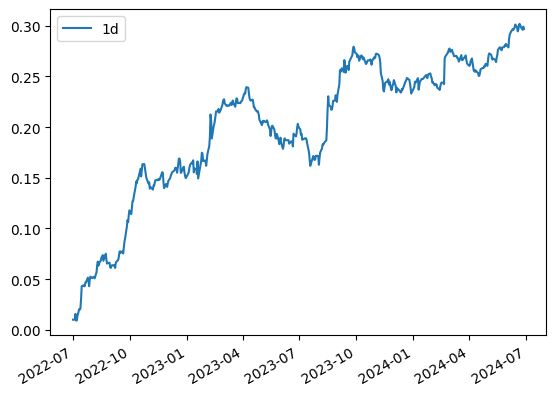

In [11]:
show_stats(res)

In [12]:
key = 'volume_imbalance'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Simple reversion

In [13]:
returns = sim.get_data('trade_pr_close').pct_change()

weights = - returns
weights = weights.ewm(com=800).mean()

# restrict universe
weights = weights.where(sim.universe_5m['top_100'])

weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe           = 5.37
Profit Margin (bps)         = 9.24
Annualized BC PnL           = 1.14
Annualized BC Overnight PnL = -0.43
Avg Daily Turnover          = 4.9
Max Drawdown                = -0.18


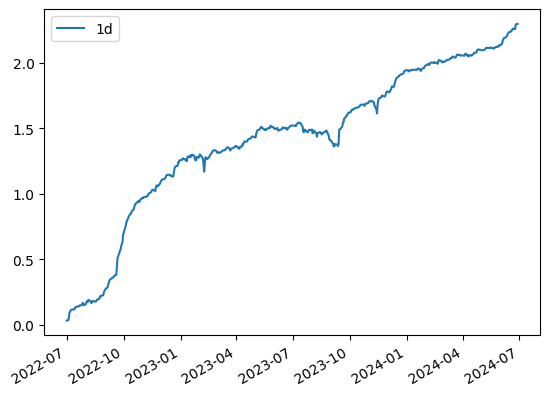

In [14]:
show_stats(res)

In [15]:
key = 'simple_reversion'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Reversion #2

In [16]:
vwap = sim.get_data('trade_pr_vwap')
close = sim.get_data('trade_pr_close')

weights = vwap / close
weights = weights.ewm(com=250).mean()

weights = weights.where(sim.universe_5m['top_100'])

weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Loading `trade_pr_vwap` from disk


Annualized Sharpe           = 5.09
Profit Margin (bps)         = 6.0
Annualized BC PnL           = 0.76
Annualized BC Overnight PnL = -0.26
Avg Daily Turnover          = 5.06
Max Drawdown                = -0.11


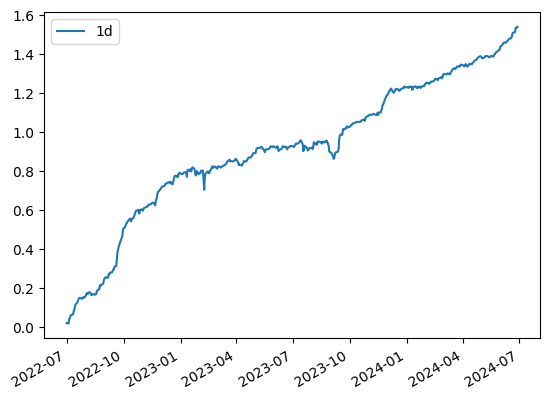

In [17]:
show_stats(res)

In [18]:
key = 'reversion_2'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Nikita #1

In [19]:
high = sim.get_data('trade_pr_high')
low = sim.get_data('trade_pr_low')
vwap = sim.get_data('trade_pr_vwap')

weights = (high*low)**(0.5) / vwap - 1
weights = weights.ewm(com=160000).mean()
weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Loading `trade_pr_high` from disk
Loading `trade_pr_low` from disk


Annualized Sharpe           = 2.75
Profit Margin (bps)         = 29.7
Annualized BC PnL           = 0.28
Annualized BC Overnight PnL = 0.2
Avg Daily Turnover          = 0.37
Max Drawdown                = -0.11


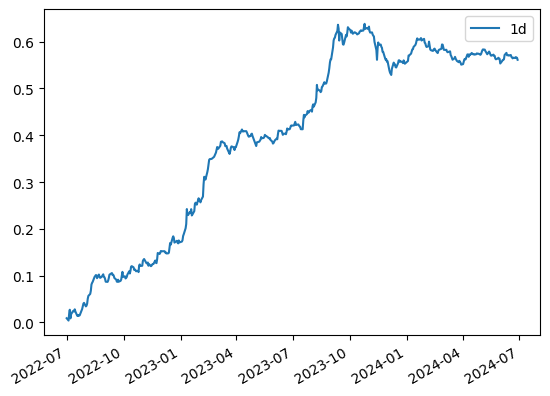

In [20]:
show_stats(res)

In [21]:
key = 'nikita_1'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Seryoga #2

In [22]:
ob_val_b = sim.get_data('orderbook_val_b') 
ob_val_s = sim.get_data('orderbook_val_s') 
 
weights = (ob_val_b - ob_val_s) / (ob_val_b + ob_val_s) 
weights = weights.ewm(com=200).mean() 
weights = weights.where(sim.universe_5m['top_100']) 
weights = truncate_and_normalize(weights, 0.04) 
 
res = sim.run_weights(weights)

Loading `orderbook_val_b` from disk
Loading `orderbook_val_s` from disk


Annualized Sharpe           = 5.61
Profit Margin (bps)         = 34.1
Annualized BC PnL           = 0.4
Annualized BC Overnight PnL = 0.09
Avg Daily Turnover          = 0.47
Max Drawdown                = -0.06


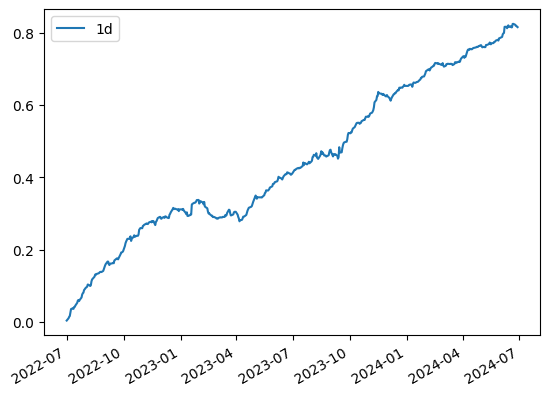

In [23]:
show_stats(res)

In [24]:
key = 'seryoga_2'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Nikita #3

In [25]:
tr_val_b = sim.get_data('trade_vol_b')  
tr_val_s = sim.get_data('trade_vol_s')

weights = ts_rank(tr_val_s, 12*4) - ts_rank(tr_val_b, 12*4)

weights = weights.ewm(com=500000).mean() 
weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Loading `trade_vol_b` from disk
Loading `trade_vol_s` from disk


Annualized Sharpe           = 2.47
Profit Margin (bps)         = 3.15
Annualized BC PnL           = 0.18
Annualized BC Overnight PnL = 0.1
Avg Daily Turnover          = 2.22
Max Drawdown                = -0.06


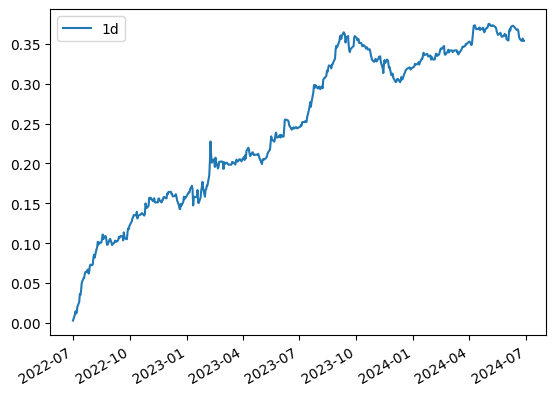

In [26]:
show_stats(res)

In [27]:
key = 'nikita_3'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Nikita #4

In [28]:
order_put_val_b = sim.get_data('order_put_val_b')
order_put_val_s = sim.get_data('order_put_val_s')

weights = ts_zscore(order_put_val_s, 12*4) - ts_zscore(order_put_val_b, 12*4)

weights = weights.ewm(com=2000).mean() 
weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Loading `order_put_val_b` from disk
Loading `order_put_val_s` from disk


Annualized Sharpe           = 1.87
Profit Margin (bps)         = 1.74
Annualized BC PnL           = 0.12
Annualized BC Overnight PnL = -0.05
Avg Daily Turnover          = 2.75
Max Drawdown                = -0.05


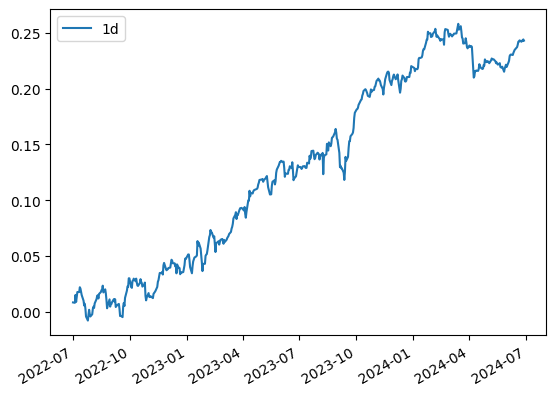

In [29]:
show_stats(res)

In [30]:
key = 'nikita_4'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Astemir #2

In [31]:
pr_vwap_ = sim.get_data('trade_pr_vwap')

left = pr_vwap_ - ts_min(pr_vwap_,12)

weights = - ts_rank(left,24)
weights = weights.ewm(com=5500).mean()
weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Annualized Sharpe           = 2.91
Profit Margin (bps)         = 8.81
Annualized BC PnL           = 0.33
Annualized BC Overnight PnL = 0.24
Avg Daily Turnover          = 1.49
Max Drawdown                = -0.1


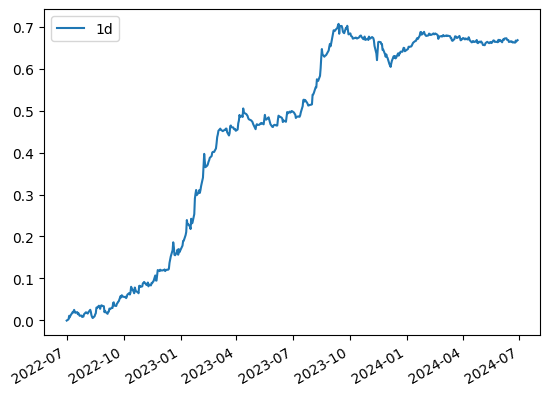

In [32]:
show_stats(res)

In [33]:
key = 'astemir_2'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Order put imbalance

In [34]:
order_put_val_s = sim.get_data('order_put_val_s')
order_put_val = sim.get_data('order_put_val')

trade_val_s = sim.get_data('trade_val_s')
trade_val = sim.get_data('trade_val')

weights = order_put_val_s / order_put_val - 0.5
weights *= 1 + trade_val_s / trade_val

weights = weights.ewm(com=50).mean()  
weights = weights.where(sim.universe_5m['top_100'])  
weights = truncate_and_normalize(weights, 0.04)  
 
res = sim.run_weights(weights)

Loading `order_put_val` from disk


Annualized Sharpe           = 4.87
Profit Margin (bps)         = 2.51
Annualized BC PnL           = 0.35
Annualized BC Overnight PnL = -0.06
Avg Daily Turnover          = 5.59
Max Drawdown                = -0.04


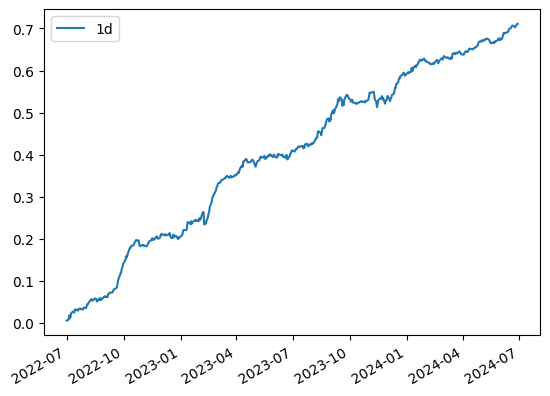

In [35]:
show_stats(res)

In [36]:
key = 'order_put_imbalance'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

Cancellations vs puts

In [37]:
order_cancel_val_b = sim.get_data('order_cancel_val_b')
order_cancel_val_s = sim.get_data('order_cancel_val_s')

order_put_val_b = sim.get_data('order_put_val_b')
order_put_val_s = sim.get_data('order_put_val_s')

trade_val_b = sim.get_data('trade_val_b')
trade_val = sim.get_data('trade_val')

weights = order_cancel_val_s / (order_cancel_val_s + order_put_val_s) - order_cancel_val_b / (order_cancel_val_b + order_put_val_b)
weights *= 1 + trade_val_b / trade_val

weights = weights.ewm(com=800).mean()

weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Loading `order_cancel_val_b` from disk
Loading `order_cancel_val_s` from disk


Annualized Sharpe           = 3.34
Profit Margin (bps)         = 8.76
Annualized BC PnL           = 0.32
Annualized BC Overnight PnL = 0.0
Avg Daily Turnover          = 1.46
Max Drawdown                = -0.06


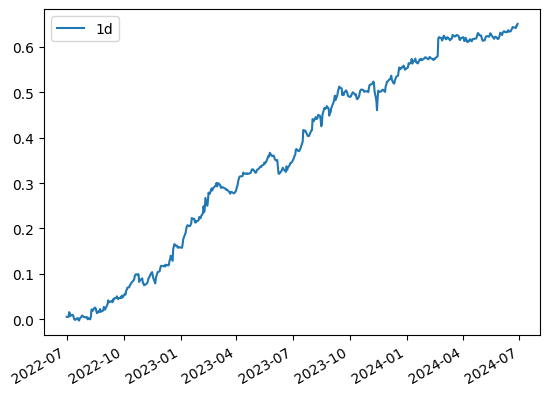

In [38]:
show_stats(res)

In [39]:
key = 'cancel_vs_put'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

High low time

In [40]:
trade_sec_pr_low = sim.get_data('trade_sec_pr_low')
trade_sec_pr_high = sim.get_data('trade_sec_pr_high')

trade_pr_low = sim.get_data('trade_pr_low')
trade_pr_high = sim.get_data('trade_pr_high')
trade_pr_close = sim.get_data('trade_pr_close')

weights = np.sign(trade_sec_pr_low - trade_sec_pr_high)

last_extr = (weights > 0) * trade_pr_low + (weights < 0) * trade_pr_high

weights *= 1 - (trade_pr_close / last_extr - 1).abs()

weights = weights.ewm(com=500).mean()

weights = weights.where(sim.universe_5m['top_100'])
weights = truncate_and_normalize(weights, 0.04)

res = sim.run_weights(weights)

Loading `trade_sec_pr_low` from disk
Loading `trade_sec_pr_high` from disk


Annualized Sharpe           = 4.01
Profit Margin (bps)         = 1.88
Annualized BC PnL           = 0.25
Annualized BC Overnight PnL = -0.05
Avg Daily Turnover          = 5.27
Max Drawdown                = -0.04


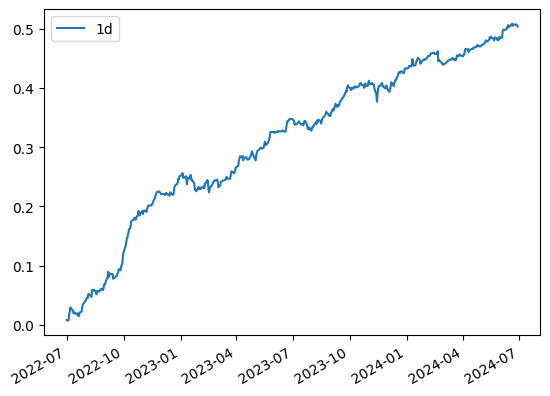

In [41]:
show_stats(res)

In [42]:
key = 'high_low_time'
WEIGHTS[key] = weights
PNL[key] = res['pnl_1d']
DRAWDOWN[key] = res['drawdown_1d']

New

---

### Correlations

In [43]:
pd.concat(PNL, axis=1).corr()

,volume_imbalance,simple_reversion,reversion_2,nikita_1,seryoga_2,nikita_3,nikita_4,astemir_2,order_put_imbalance,cancel_vs_put,high_low_time
volume_imbalance,1.000000,-0.114433,-0.164984,0.342862,-0.155400,0.229562,0.052506,0.389837,0.280541,-0.032236,-0.037322
simple_reversion,-0.114433,1.000000,0.727233,-0.306655,0.059549,-0.221492,0.257212,-0.353252,0.271085,0.230941,0.401709
reversion_2,-0.164984,0.727233,1.000000,-0.515299,0.013024,-0.366557,0.182684,-0.474185,0.204074,0.128417,0.143535
nikita_1,0.342862,-0.306655,-0.515299,1.000000,-0.200707,0.343405,-0.178909,0.611211,0.232781,0.117878,0.076300
seryoga_2,-0.155400,0.059549,0.013024,-0.200707,1.000000,-0.041876,0.050980,-0.151889,-0.324641,-0.129332,-0.168418
nikita_3,0.229562,-0.221492,-0.366557,0.343405,-0.041876,1.000000,-0.095297,0.339196,0.147638,-0.082165,0.086366
nikita_4,0.052506,0.257212,0.182684,-0.178909,0.050980,-0.095297,1.000000,-0.078322,0.145084,0.135769,0.024985
astemir_2,0.389837,-0.353252,-0.474185,0.611211,-0.151889,0.339196,-0.078322,1.000000,0.225269,0.071299,-0.017217
order_put_imbalance,0.280541,0.271085,0.204074,0.232781,-0.324641,0.147638,0.145084,0.225269,1.000000,0.356708,0.194923
cancel_vs_put,-0.032236,0.230941,0.128417,0.117878,-0.129332,-0.082165,0.135769,0.071299,0.356708,1.000000,0.089564


In [44]:
pd.concat(DRAWDOWN, axis=1).corr()

,volume_imbalance,simple_reversion,reversion_2,nikita_1,seryoga_2,nikita_3,nikita_4,astemir_2,order_put_imbalance,cancel_vs_put,high_low_time
volume_imbalance,1.000000,0.151265,0.106143,0.122186,-0.222116,0.167399,-0.219620,0.318571,0.164918,0.172014,-0.033010
simple_reversion,0.151265,1.000000,0.812653,-0.254379,0.084061,-0.242846,0.125081,-0.245101,0.003543,0.046795,0.154941
reversion_2,0.106143,0.812653,1.000000,-0.281431,0.173048,-0.194979,0.076386,-0.258522,0.004907,-0.024702,0.257733
nikita_1,0.122186,-0.254379,-0.281431,1.000000,-0.219055,0.542286,0.338872,0.830295,0.135126,-0.037340,-0.048170
seryoga_2,-0.222116,0.084061,0.173048,-0.219055,1.000000,0.222998,-0.135860,-0.211150,-0.116175,-0.065500,0.223246
nikita_3,0.167399,-0.242846,-0.194979,0.542286,0.222998,1.000000,-0.243083,0.670457,0.335496,0.031547,0.203650
nikita_4,-0.219620,0.125081,0.076386,0.338872,-0.135860,-0.243083,1.000000,0.139486,-0.127350,0.023424,-0.103585
astemir_2,0.318571,-0.245101,-0.258522,0.830295,-0.211150,0.670457,0.139486,1.000000,0.342428,0.094769,-0.050033
order_put_imbalance,0.164918,0.003543,0.004907,0.135126,-0.116175,0.335496,-0.127350,0.342428,1.000000,0.402420,0.135981
cancel_vs_put,0.172014,0.046795,-0.024702,-0.037340,-0.065500,0.031547,0.023424,0.094769,0.402420,1.000000,0.017410


---

### Equal-weighted combo

In [45]:
weights_concat = pd.concat(WEIGHTS, axis=1)

In [46]:
combo_ew = weights_concat.fillna(0).groupby(level=1, axis=1).mean().where(weights_concat.notna().groupby(level=1, axis=1).any())
combo_ew = scale(combo_ew)

In [47]:
ew_weights = combo_ew.ewm(com=1).mean()
ew_weights = ew_weights.where(sim.universe_5m['top_100'])
ew_weights = truncate_and_normalize(ew_weights, 0.04)

In [92]:
ew_res = sim.run_weights(ew_weights)

Annualized Sharpe           = 7.62
Profit Margin (bps)         = 8.63
Annualized BC PnL           = 0.76
Annualized BC Overnight PnL = -0.06
Avg Daily Turnover          = 3.51
Max Drawdown                = -0.08


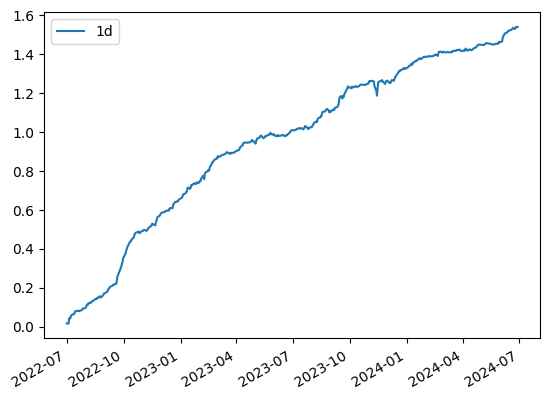

In [93]:
show_stats(ew_res)

### MARKOWITZ

In [50]:
def sharpe(pnl): 
      return np.sqrt(365) * pnl.mean() / pnl.std()

In [51]:
pnl = pd.DataFrame({wname: (returns * w.shift()).sum(axis=1) for wname, w in WEIGHTS.items()})
daily_pnl = pnl.resample('1d').sum().loc[sim.dates]

In [85]:
ndays = 63

solution = dict()

for dti in tqdm(list(range(ndays-1, daily_pnl.shape[0]))):
    start_dt = daily_pnl.index[dti-ndays+1]
    end_dt = daily_pnl.index[dti]
    
    P = 1e3 * daily_pnl.loc[start_dt:end_dt]
    
    alpha_names = P.columns
    n = alpha_names.size
    
    m = P.mean().values
    sigma = P.cov().values
    
#     if np.linalg.det(sigma) < 1e-55:
#         print (end_dt, 'Singular covariance structure')
#         solution[end_dt] = pd.Series(1/n, index=alpha_names)
#         continue

    c_ew = np.repeat(1/n,n) 
    a_ew = np.dot(c_ew,m) / c_ew.dot(sigma).dot(c_ew) 

    # risk aversion 
    a = 2 * a_ew 

    # run optimization c.dot(m) - a * c.dot(sigma).dot(c) --> max 
    w = cp.Variable(n,nonneg=True) 

    constraints = [ 
        cp.sum(w) == 1 
    ] 

    p = cp.Problem( 
        cp.Maximize(m @ w - a * cp.quad_form(w,sigma)), 
        constraints 
    ) 
    p.solve()

    solution[end_dt] = pd.Series(w.value, index=alpha_names)

  0%|          | 0/446 [00:00<?, ?it/s]

In [86]:
alpha_weights = pd.concat(solution, axis=0).unstack(level=1).shift().reindex(index=sim.dates)
alpha_weights.index = alpha_weights.index.map(lambda x: pd.to_datetime(x) + pd.Timedelta(sim.session_start_time) + pd.Timedelta(minutes=5))
alpha_weights = alpha_weights.reindex(index=sim.timeline_5m).ffill()

In [87]:
opt_weights = weights_concat.mul(alpha_weights, level=0).groupby(level=1, axis=1).sum().where(weights_concat.notnull().groupby(level=1, axis=1).max())
opt_weights = opt_weights.div(opt_weights.abs().sum(axis=1), axis=0)

In [88]:
opt_weights_1 = opt_weights.copy()
opt_weights_1 = opt_weights_1.ewm(com=0.35).mean()

In [89]:
opt_weights_1 = opt_weights_1.where(sim.universe_5m['top_100'])
opt_weights_1 = truncate_and_normalize(opt_weights_1, 0.04)

In [90]:
opt_res = sim.run_weights(opt_weights_1, start_date='2022-10-01')

Annualized Sharpe           = 9.39
Profit Margin (bps)         = 8.4
Annualized BC PnL           = 0.73
Annualized BC Overnight PnL = 0.06
Avg Daily Turnover          = 3.43
Max Drawdown                = -0.04


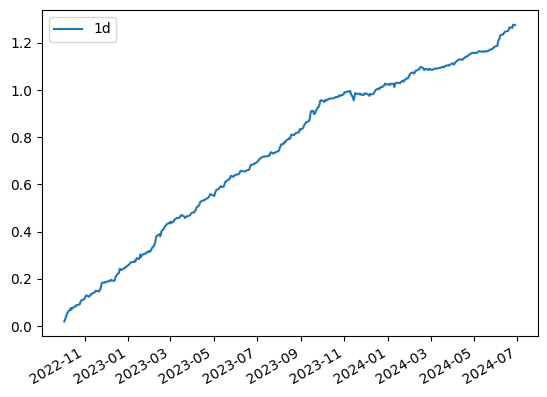

In [91]:
show_stats(opt_res)

In [94]:
ew_res = sim.run_weights(ew_weights, start_date='2022-10-01')

Annualized Sharpe           = 6.88
Profit Margin (bps)         = 7.81
Annualized BC PnL           = 0.68
Annualized BC Overnight PnL = -0.03
Avg Daily Turnover          = 3.45
Max Drawdown                = -0.08


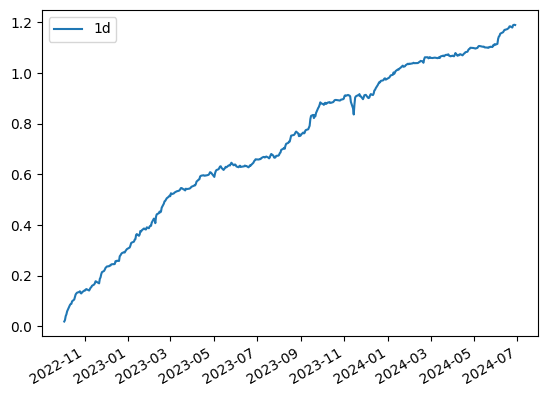

In [95]:
show_stats(ew_res)